# 03b Start exploring the differential diagnosis datasets 

> Initial exploration of the data   

In [1]:
#|default_exp core.03b_explore_differential_datasets

In [2]:
#|hide
#import nbdev; nbdev.nbdev_export()

In [3]:
#|hide
from nbdev.showdoc import show_doc

In [4]:
#|export
import dementia_inequalities as proj
from dementia_inequalities import const, log, utils, tools
import adu_proj.utils as adutils

In [5]:
#|export
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn import linear_model

import statsmodels.api as sm 
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

--- 

This notebook looks at some analysis of the [Primary Care Dementia Data - December 2023](https://digital.nhs.uk/data-and-information/publications/statistical/primary-care-dementia-data/december-2023#summary), locally located here:

`dementia_inequalities/store/data/differential_diagnosis/pcdem-sicbl-dem-type-dec-2023.csv`

In [16]:
#|export 
df_icb_diff = pd.read_csv(const.data_path+'/differential_diagnosis/pcdem-sicbl-dem-type-dec-2023.csv')
df_young = pd.read_csv(const.data_path+ '/differential_diagnosis/pcdem-sicbl-incidence-onset-dec-2023.csv')

In [7]:
df_icb_diff.head()

,ACH_DATE,REGION_ODS_CODE,REGION_ONS_CODE,REGION_NAME,ICB_ODS_CODE,ICB_ONS_CODE,ICB_NAME,SUB_ICB_ODS_CODE,SUB_ICB_ONS_CODE,SUB_ICB_NAME,Measure,Value
0,31-Dec-23,Y56,E40000003,London,QKK,E54000030,NHS South East London Integrated Care Board,72Q,E38000244,NHS South East London ICB - 72Q,ALZHEIMERS_DISEASE,5345.0
1,31-Dec-23,Y56,E40000003,London,QKK,E54000030,NHS South East London Integrated Care Board,72Q,E38000244,NHS South East London ICB - 72Q,MIXED_DEMENTIA_TYPES,625.0
2,31-Dec-23,Y56,E40000003,London,QKK,E54000030,NHS South East London Integrated Care Board,72Q,E38000244,NHS South East London ICB - 72Q,OTHER_DEMENTIA_TYPES,2690.0
3,31-Dec-23,Y56,E40000003,London,QKK,E54000030,NHS South East London Integrated Care Board,72Q,E38000244,NHS South East London ICB - 72Q,VASCULAR_DEMENTIA,1940.0
4,31-Dec-23,Y56,E40000003,London,QMF,E54000029,NHS North East London Integrated Care Board,A3A8R,E38000255,NHS North East London ICB - A3A8R,ALZHEIMERS_DISEASE,3620.0


In [8]:
hist_df = df_icb_diff[df_icb_diff['Measure']=='ALZHEIMERS_DISEASE'][['ICB_NAME','Value']]

hist_df.columns = ['ICB', 'Alzheimers']

hist_df['Vascular'] = df_icb_diff[df_icb_diff['Measure']=='VASCULAR_DEMENTIA']['Value'].values
hist_df['Mixed'] = df_icb_diff[df_icb_diff['Measure']=='MIXED_DEMENTIA_TYPES']['Value'].values
hist_df['Other'] = df_icb_diff[df_icb_diff['Measure']=='OTHER_DEMENTIA_TYPES']['Value'].values

#hist_df.replace('*', '', inplace=True)
#hist_df[['Alzheimers', 'Vascular', 'Mixed', 'Other']].astype(float)

hist_df['Alzheimers'] = pd.to_numeric(hist_df['Alzheimers'], errors='coerce')
hist_df['Vascular'] = pd.to_numeric(hist_df['Vascular'], errors='coerce')
hist_df['Mixed'] = pd.to_numeric(hist_df['Mixed'], errors='coerce')
hist_df['Other'] = pd.to_numeric(hist_df['Other'], errors='coerce')

In [24]:
hist_df

,ICB,Alzheimers,Vascular,Mixed,Other,Total_dementia
0,"Bath and North East Somerset, Swindon and Wilt...",27305.0,6970.0,4005.0,33865.0,72145.0
1,"Bedfordshire, Luton and Milton Keynes",26965.0,6855.0,2445.0,28600.0,64865.0
2,Birmingham and Solihull,32530.0,18520.0,3720.0,25320.0,80090.0
3,Black Country,22650.0,20615.0,8150.0,33575.0,84990.0
4,"Bristol, North Somerset and South Gloucestershire",25735.0,14515.0,4930.0,27830.0,73010.0
5,"Buckinghamshire, Oxfordshire and Berkshire West",61780.0,16510.0,7420.0,41005.0,126715.0
6,Cambridgeshire and Peterborough,27930.0,7335.0,2390.0,21165.0,58820.0
7,Cheshire and Merseyside,95165.0,44650.0,13195.0,53335.0,206345.0
8,Cornwall and the Isles of Scilly,18700.0,13700.0,2030.0,16925.0,51355.0
9,Coventry and Warwickshire,26350.0,11230.0,5360.0,21085.0,64025.0


In [10]:
# reformat the ICB names 
unecessary_words = ['NHS', 'Integrated', 'Care', 'Board', 'ICB']
f = lambda x: ' '.join([item for item in x.split() if item not in unecessary_words])
hist_df['ICB'] = hist_df['ICB'].apply(f)

# group 
hist_df = hist_df.groupby('ICB')[['Alzheimers', 'Vascular', 'Mixed', 'Other']].sum()
hist_df.reset_index(inplace=True)

# add column with total dementia cases
hist_df['Total_dementia'] = hist_df[['Alzheimers', 'Vascular', 'Mixed', 'Other']].sum(axis=1)

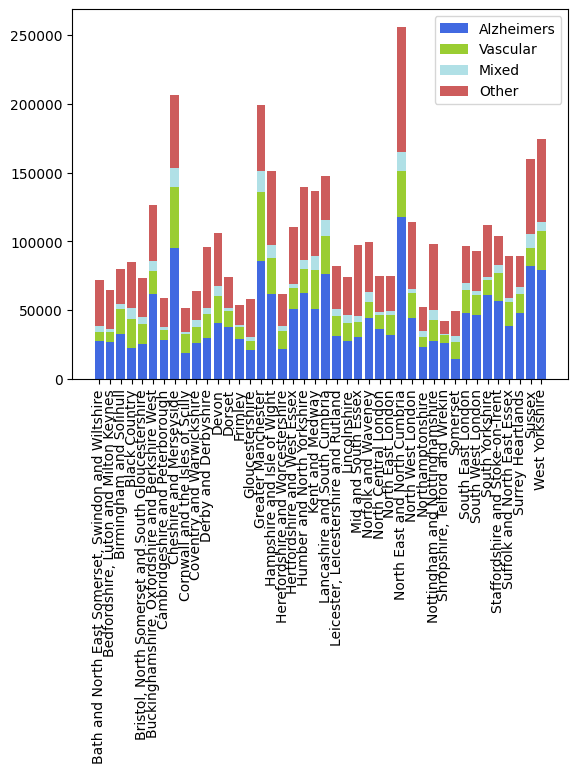

In [11]:
x =  hist_df['ICB'].values
y1 = hist_df['Alzheimers'].values
y2 = hist_df['Vascular'].values
y3 = hist_df['Mixed'].values
y4 = hist_df['Other'].values

plt.bar(x, y1, color='royalblue')
plt.bar(x, y2, bottom=y1, color='yellowgreen')
plt.bar(x, y3, bottom=y1+y2, color='powderblue')
plt.bar(x, y4, bottom=y1+y2+y3, color='indianred')
plt.legend(['Alzheimers', 'Vascular', 'Mixed', 'Other'])
plt.xticks(rotation=90)
plt.show()

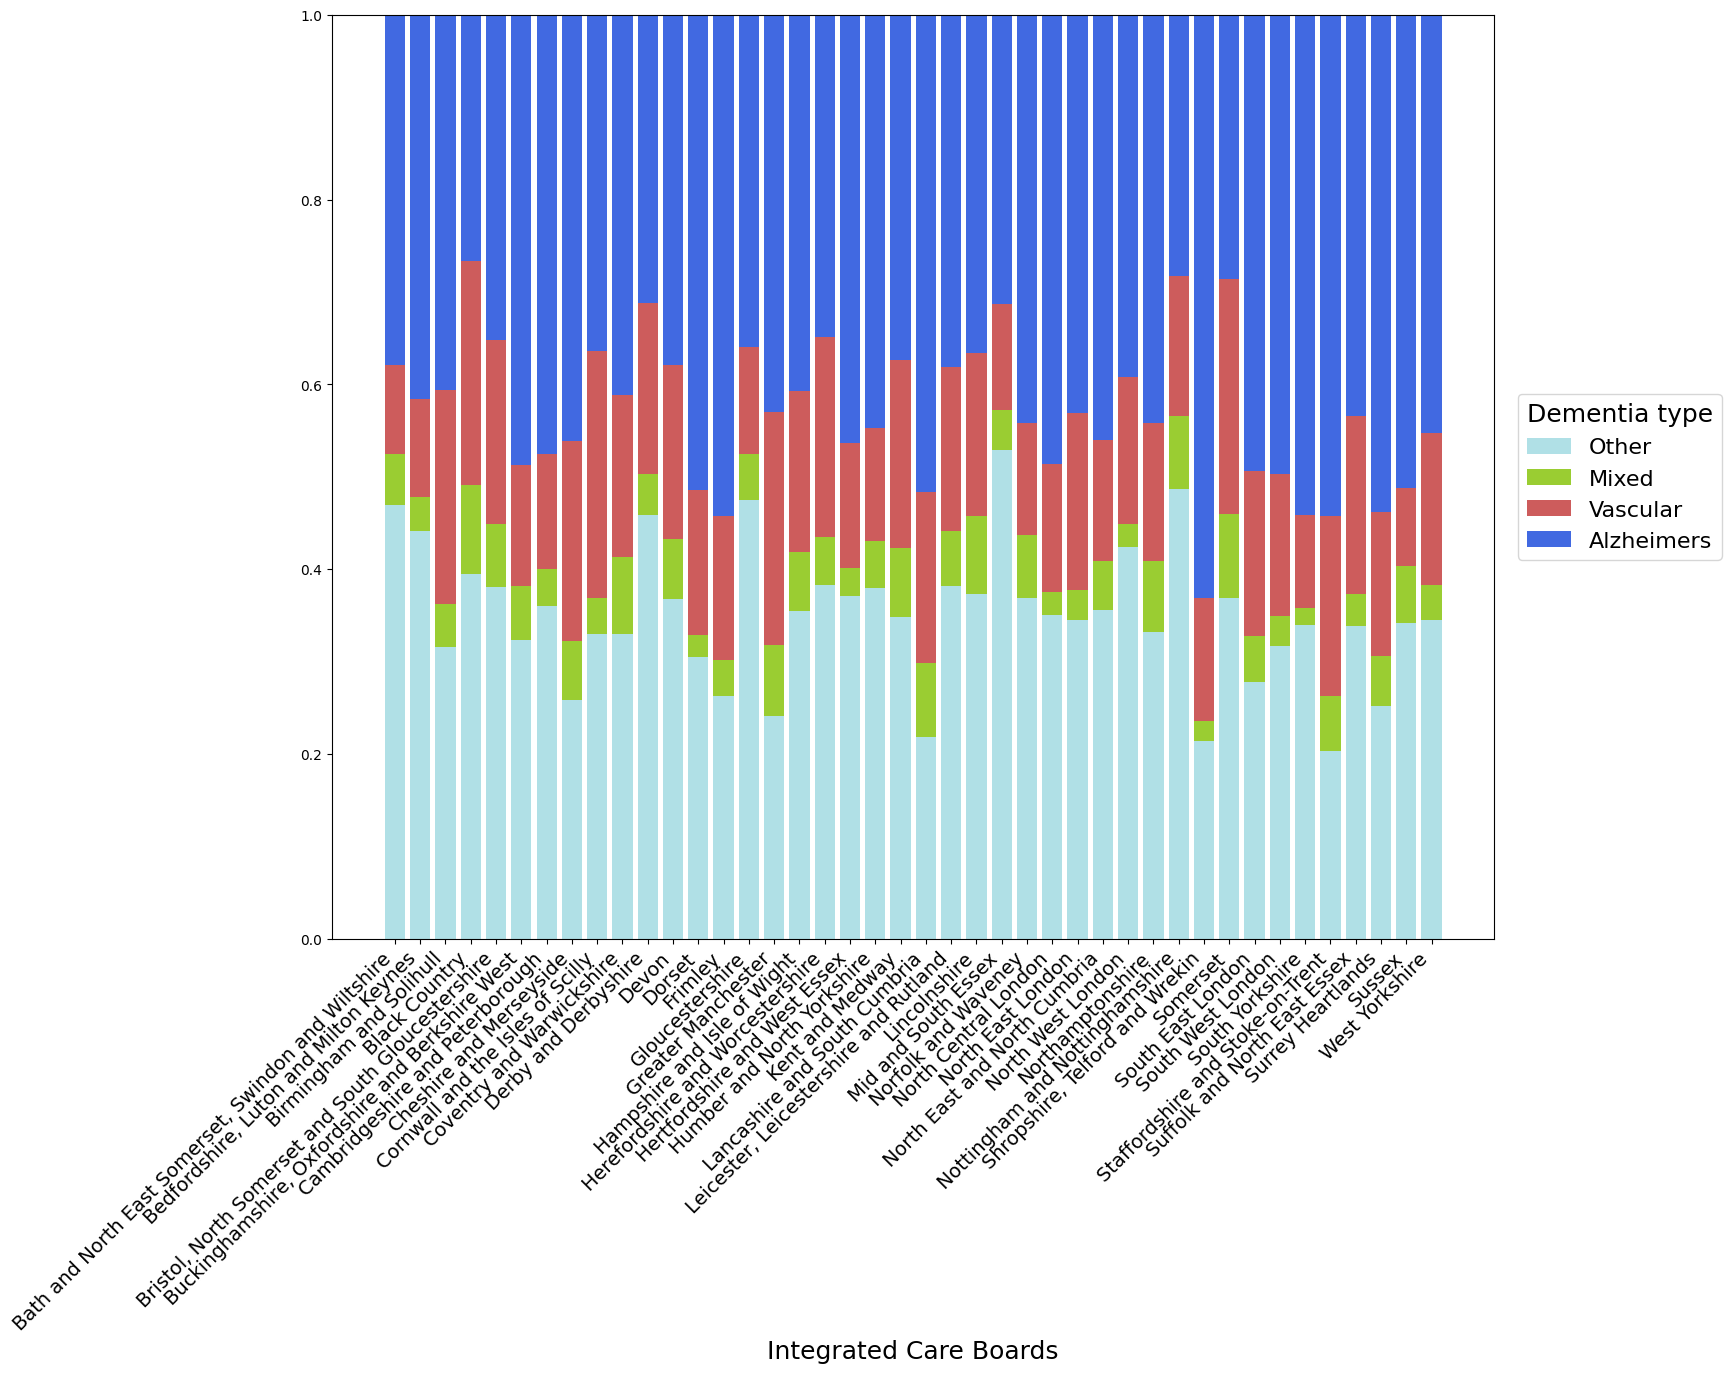

In [12]:
tot = hist_df['Total_dementia'].values
x =  hist_df['ICB'].values
y1 = hist_df['Other'].values
y2 = hist_df['Mixed'].values
y3 = hist_df['Vascular'].values
y4 = hist_df['Alzheimers'].values

plt.figure(figsize=(15,12))
plt.bar(x, y1/tot, color='powderblue')
plt.bar(x, y2/tot, bottom=y1/tot, color='yellowgreen')
plt.bar(x, y3/tot, bottom=(y1+y2)/tot, color='indianred')
plt.bar(x, y4/tot, bottom=(y1+y2+y3)/tot, color='royalblue')
plt.legend(['Other', 'Mixed', 'Vascular', 'Alzheimers'],title='Dementia type', title_fontsize=18, fontsize=16, bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
plt.ylim(0,1)
plt.xlabel('Integrated Care Boards', fontsize=18)
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.show()

In [17]:
df_icb_young =  df_young[df_young['ORG_TYPE']=='ICB']

In [19]:
df_icb_young

,ACH_DATE,ORG_TYPE,ORG_CODE,ONS_CODE,NAME,Measure,Value
4,31-Dec-23,ICB,QOX,E54000040,"NHS Bath and North East Somerset, Swindon and ...",INCIDENCE,139
5,31-Dec-23,ICB,QOX,E54000040,"NHS Bath and North East Somerset, Swindon and ...",YOUNG_ONSET,477
6,31-Dec-23,ICB,QOX,E54000040,"NHS Bath and North East Somerset, Swindon and ...",DEMENTIA_REGISTER,8095
7,31-Dec-23,ICB,QOX,E54000040,"NHS Bath and North East Somerset, Swindon and ...",PAT_LIST_ALL,1003016
8,31-Dec-23,ICB,QHG,E54000024,"NHS Bedfordshire, Luton and Milton Keynes Inte...",INCIDENCE,68
...,...,...,...,...,...,...,...
5159,30-Apr-23,ICB,QNX,E54000064,NHS Sussex ICB,PAT_LIST_ALL,1833806
5160,30-Apr-23,ICB,QWO,E54000054,NHS West Yorkshire Integrated Care Board,INCIDENCE,251
5161,30-Apr-23,ICB,QWO,E54000054,NHS West Yorkshire Integrated Care Board,YOUNG_ONSET,1647
5162,30-Apr-23,ICB,QWO,E54000054,NHS West Yorkshire Integrated Care Board,DEMENTIA_REGISTER,18869


In [21]:
young_hist_df = df_icb_young[df_icb_young['Measure']=='YOUNG_ONSET'][['NAME','Value']]

young_hist_df.columns = ['ICB', 'Young_onset']

young_hist_df['Total_patient_list'] = df_icb_young[df_icb_young['Measure']=='PAT_LIST_ALL']['Value'].values
young_hist_df['Total_dementia'] = df_icb_young[df_icb_young['Measure']=='DEMENTIA_REGISTER']['Value'].values

young_hist_df['Young_onset'] = pd.to_numeric(young_hist_df['Young_onset'], errors='coerce')
young_hist_df['Total_patient_list'] = pd.to_numeric(young_hist_df['Total_patient_list'], errors='coerce')
young_hist_df['Total_dementia'] = pd.to_numeric(young_hist_df['Total_dementia'], errors='coerce')

In [22]:
# reformat the ICB names 
young_hist_df['ICB'] = young_hist_df['ICB'].apply(f)

# group 
young_hist_df = young_hist_df.groupby('ICB')[['Young_onset', 'Total_patient_list', 'Total_dementia']].sum()
young_hist_df.reset_index(inplace=True)

In [23]:
young_hist_df

,ICB,Young_onset,Total_patient_list,Total_dementia
0,"Bath and North East Somerset, Swindon and Wilt...",4288,8945227,71284
1,"Bedfordshire, Luton and Milton Keynes",5799,10028344,64216
2,Birmingham and Solihull,6863,14432323,80279
3,Black Country,7333,11796397,84975
4,"Bristol, North Somerset and South Gloucestershire",4191,9703816,73365
5,"Buckinghamshire, Oxfordshire and Berkshire West",6131,17816609,127516
6,Cambridgeshire and Peterborough,4809,9274440,58171
7,Cheshire and Merseyside,14075,24804954,207326
8,Cornwall and the Isles of Scilly,2908,5361884,50985
9,Coventry and Warwickshire,4334,9793764,64824


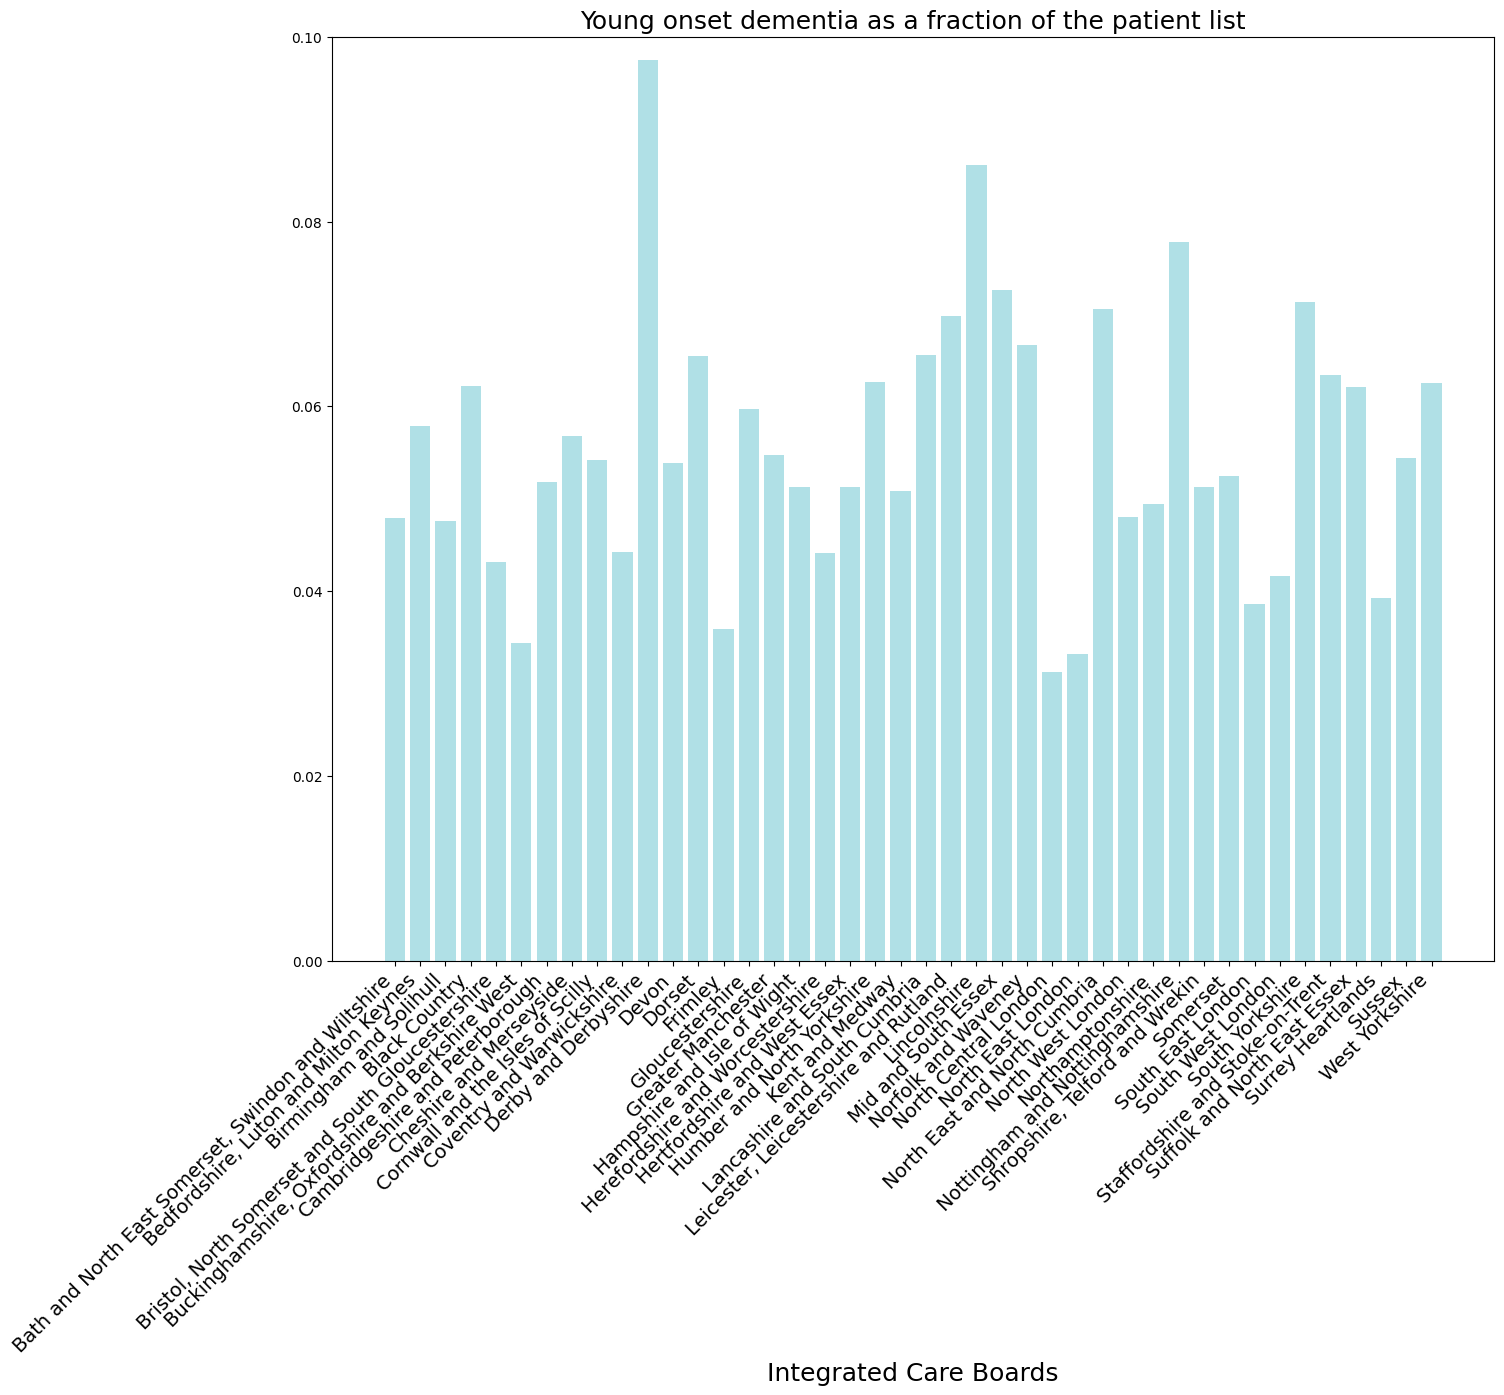

In [43]:
tot = young_hist_df['Total_patient_list'].values
x =  young_hist_df['ICB'].values
y1 = young_hist_df['Young_onset'].values

plt.figure(figsize=(15,12))
plt.bar(x, y1/tot*100, color='powderblue')
plt.title('Young onset dementia as a fraction of the patient list', fontsize=18)
#plt.legend(['Young onset', 'All dementia'],title='Dementia type', title_fontsize=18, fontsize=16, bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
plt.ylim(0,0.1)
plt.xlabel('Integrated Care Boards', fontsize=18)
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.show()

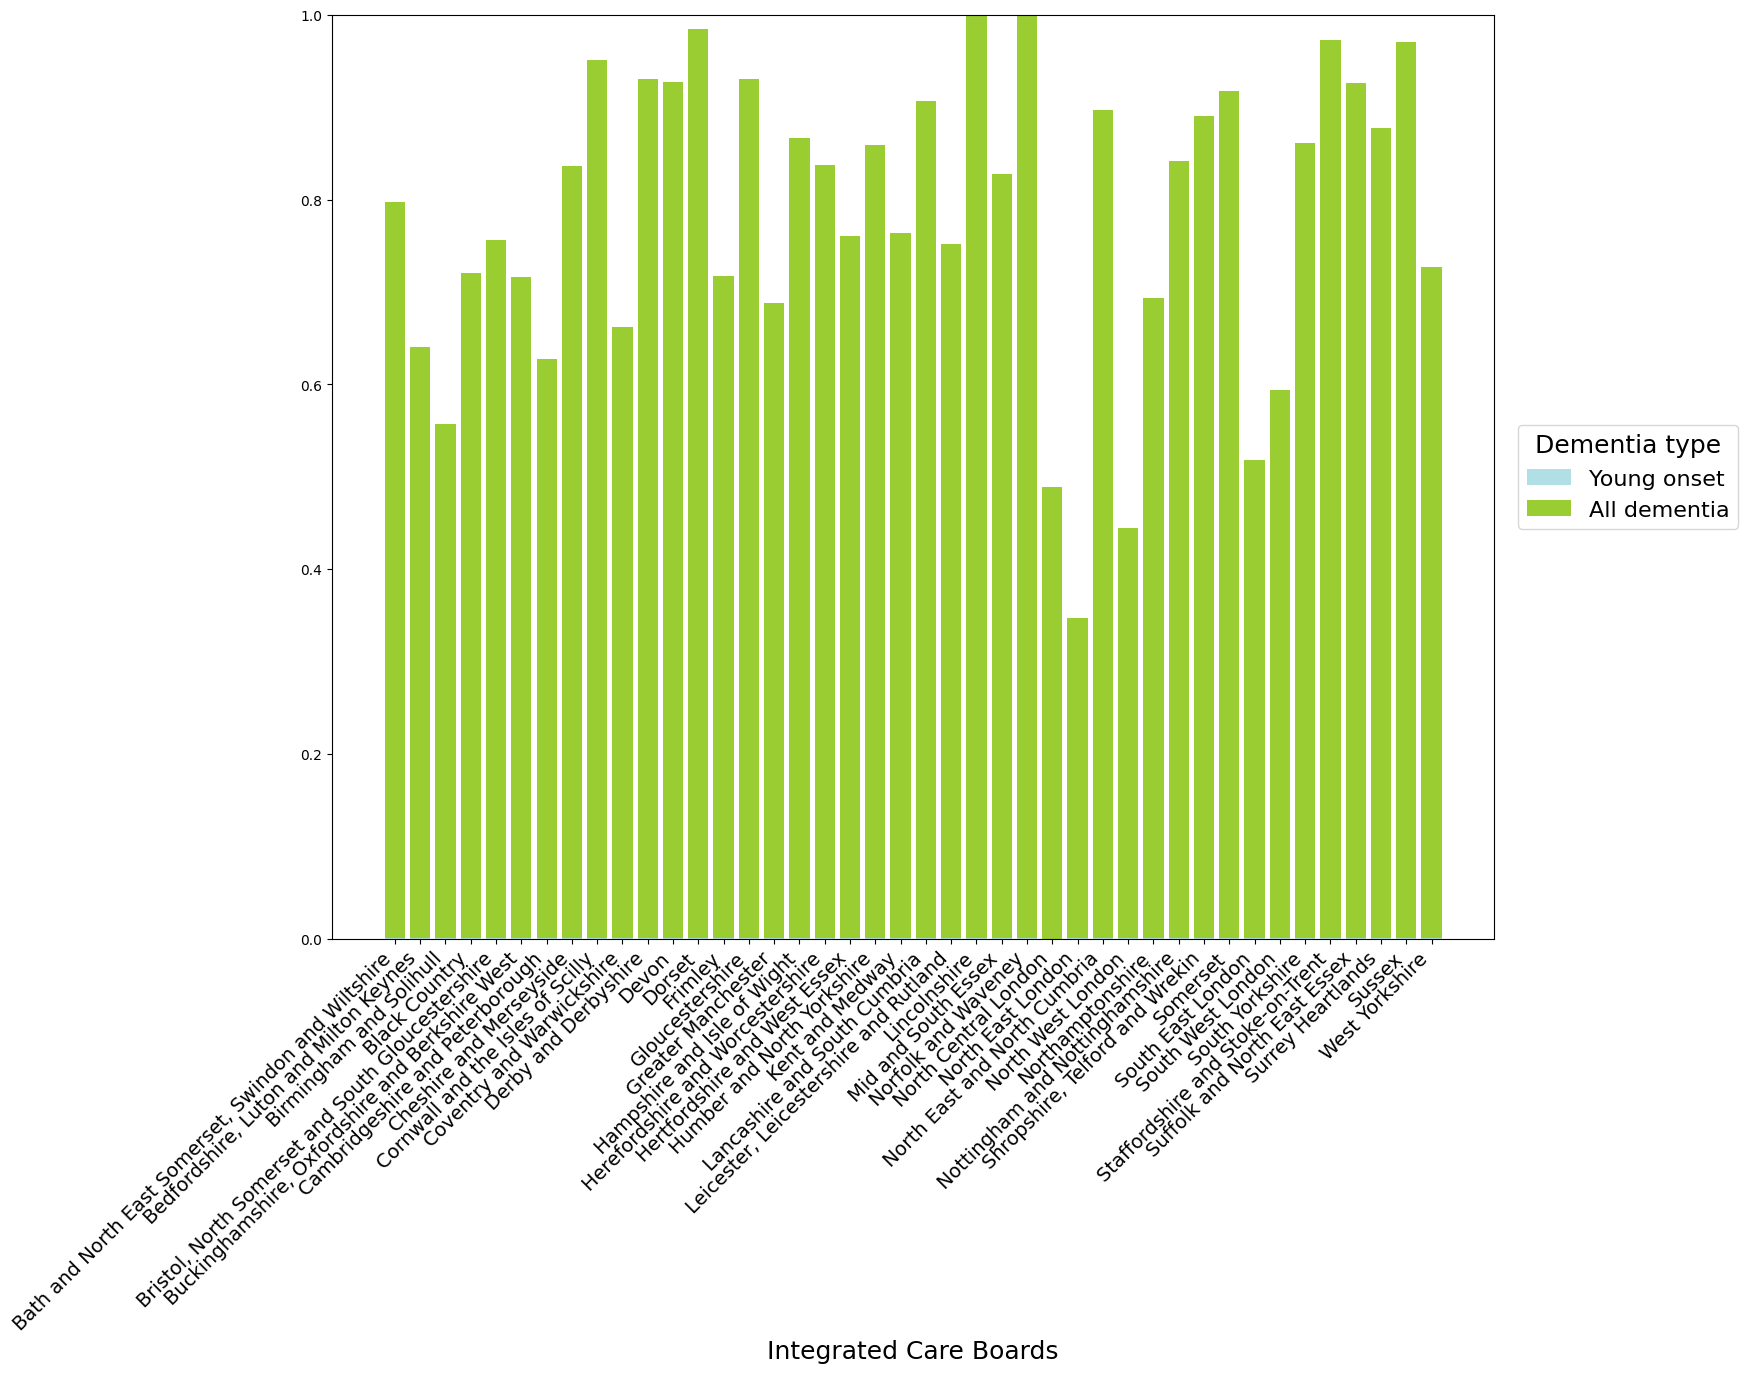

In [30]:
tot = young_hist_df['Total_patient_list'].values
x =  young_hist_df['ICB'].values
y1 = young_hist_df['Young_onset'].values
y2 = young_hist_df['Total_dementia'].values

plt.figure(figsize=(15,12))
plt.bar(x, y1/tot*100, color='powderblue')
plt.bar(x, y2/tot*100, bottom=y1/tot, color='yellowgreen')
plt.legend(['Young onset', 'All dementia'],title='Dementia type', title_fontsize=18, fontsize=16, bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
plt.ylim(0,1)
plt.xlabel('Integrated Care Boards', fontsize=18)
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.show()